In [1]:
# by Talha oz (@tozCSS)

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline
import seaborn as sns
colpal = sns.color_palette("hls", 7)
sns.set(palette=colpal, rc={"figure.figsize":(7.75,5),'savefig.dpi':150})

In [2]:
# read data in
df = pd.read_csv('data/listings.csv',index_col='id')
revcols = 'host_id	host_listings_count	number_of_reviews	review_scores_rating	review_scores_accuracy	review_scores_cleanliness	review_scores_checkin	review_scores_communication	review_scores_location	review_scores_value'.split('\t')
df = df.dropna(subset=revcols).sort('review_scores_rating',ascending=False)
df = df.rename(columns=dict(zip(revcols[3:],[c.split('_')[-1] for c in revcols[3:]])))
df = df.rename(columns={'neighbourhood_cleansed':'neighborhood'})
revcols = [c.split('_')[-1] for c in revcols[4:]]

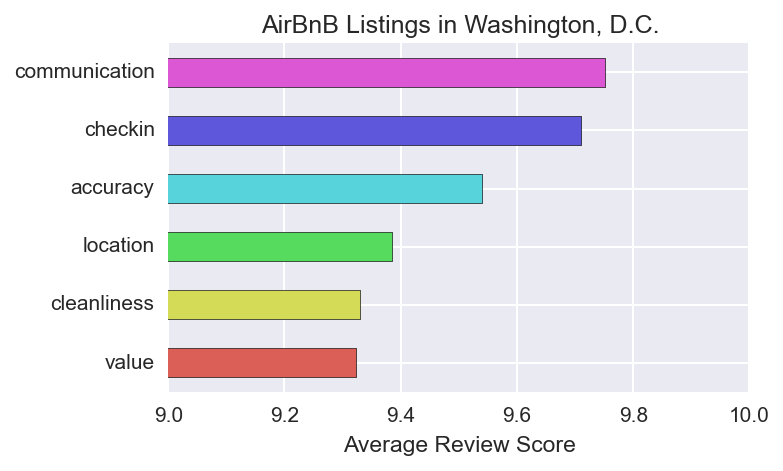

In [3]:
dd = df[revcols].sum()/len(df)
#ax = sns.barplot(y=dd.index,x=dd.values)
ax = dd.order().plot(kind='barh',color=sns.color_palette('hls'),figsize=(5,3))
ax.set(xlim=(9,10),xlabel='Average Review Score',title='AirBnB Listings in Washington, D.C.');

In [4]:
#export related fields to a csv file
df[revcols] = df[revcols].astype(int)
df[['host_id']+revcols+['number_of_reviews','listing_url','name','neighborhood','room_type','description','latitude','longitude']].to_csv('data/reviewed_listings.csv',encoding='utf8')

## CSV to PostGIS
I filtered the original listings file and selected only a subset of the attributes that are relevant to my geo-web app
and exported it into a CSV file (`reviewed_listings.csv`) using Pandas library in Python.

On the database (Postgres) side, I first created a database (named `airbnb`) and extended it with `postgis` extension. I then created the `listings` table to keep the reviewed listings in the Washington, D.C. area as follows:

```CREATE TABLE listings (
    id integer PRIMARY KEY,
    host_id integer,
    accuracy integer,
    cleanliness integer,
    checkin integer,
    communication integer,
    location integer,
    value integer,
    number_of_reviews integer,
    listing_url character varying(50),
    name character varying(50),
    neighborhood character varying(100),
    room_type character varying(15),
    description character varying(1000),
    latitude double precision,
    longitude double precision
);```

I then copied the records in the CSV file to this table using the `copy` command in postgres:
`copy listings from '/home/ggs/Desktop/reviewed_listings.csv' DELIMITERS ',' CSV HEADER;`
Latitute and longitude data (which was imported as `double precision`) are now to be converted to PostGIS geometry (point) object with the following code:

    alter table listings add column the_geom geometry;
    update listings set the_geom = ST_GeomFromText('POINT(' || longitude || ' ' || latitude || ')',4326);